In [167]:
from PIL import Image
import matplotlib.pyplot as plt
import pydicom
import torch
import numpy as np
from torch.nn import NLLLoss, Module, Linear, Dropout, LogSoftmax, Sequential, Flatten
from torch.optim import Adam
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Practice 1

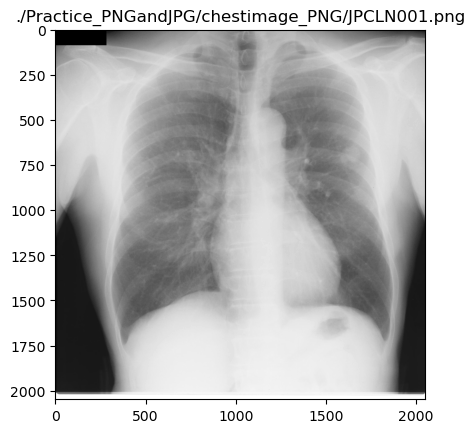

In [208]:
image_path = './Practice_PNGandJPG/chestimage_PNG/JPCLN001.png'
img = Image.open(image_path, )
plt.imshow(img, cmap='gray')
plt.title(image_path)
plt.show()

# Practice 2

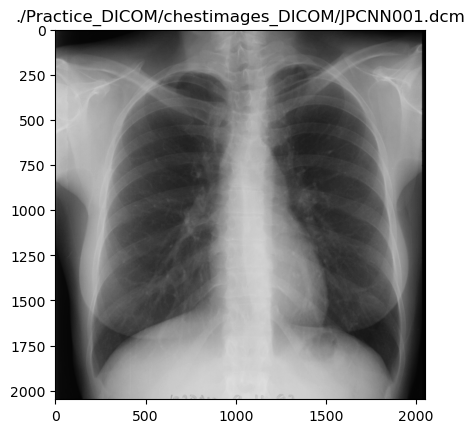

In [209]:
image_path = './Practice_DICOM/chestimages_DICOM/JPCNN001.dcm'

pixels = pydicom.dcmread(image_path).pixel_array

plt.imshow(pixels, cmap='gray')
plt.title(image_path)
plt.show()

# Directions 1

In [182]:
def parse(data_indicator):
    _, split, label, path =  data_indicator.split("\\")
    path = path.strip()
    path = path.split(',')[0]
    return split, label, path


def read_image(path):
    img = Image.open(path)
    return img


def turn_label(label):
    if label == 'up':
        return 0
    elif label == 'down':
        return 1
    elif label == 'left':
        return 2
    elif label == 'right':
        return 3


def do_with_data(path_for_data):
    with open(path_for_data) as fp:
        data_indicators = fp.readlines()
    
    splits, labels, paths = [], [], []
    for i in data_indicators:
        split, label, path = parse(i)
        splits.append(split)
        labels.append(label)
        paths.append(path)

    return splits, labels, paths

train_splits, train_labels, train_paths = do_with_data('./Directions01_RGB/list_train.txt')
test_splits, test_labels, test_paths = do_with_data('./Directions01_RGB/test_list.txt')


In [177]:
def prepare_data(paths, labels, splits):
    images = []
    labels_out = []
    split = splits[0]
    for path, label in zip(paths, labels):
        
        image = read_image(f'./Directions01_RGB/{split}/{label}/{path}')
        images.append(image)
        labels_out.append(turn_label(label))
    index = torch.randperm(len(labels))

    # images = np.stack(images)
    labels_out = torch.tensor([labels_out[i] for i in index])
    images = [images[i] for i in index]

    return images, labels_out


# Modeling

In [118]:
class Classifier(Module):
    def __init__(self, output_size, dropout_rate):
        super(Classifier, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        in_feature = self.resnet18.fc.in_features
        self.resnet18 = Sequential(*list(self.resnet18.children())[:-1])
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        # Apply the transformation to the image
        # tensor_image = transform(png_image)
        # self.input_size = input_size
        self.output_size = output_size 
        self.flatten = Flatten(1, -1)
        self.classifier = Linear(in_features=in_feature, out_features=output_size)
        self.dropout_rate = dropout_rate
        self.regularizer = Dropout(self.dropout_rate)
        self.clf_func = LogSoftmax(dim=-1)

    def forward(self, x):
        x = torch.stack([self.transform(i) for i in x])
        # x = self.transform(x)
        hidden = self.resnet18(x)
        hidden = self.flatten(hidden)
        
        hidden = self.classifier(hidden)
        hidden = self.regularizer(hidden)
        return self.clf_func(hidden)
        # self.resnet_features = nn.Sequential(*list(resnet18.children())

In [119]:
def train(model, x, y, optimizer, loss_fn):
    model.train()

    optimizer.zero_grad()

    y_hat = model(x)

    loss = loss_fn(y_hat, y)

    loss.backward()

    optimizer.step()

    return loss.item()

In [192]:
@torch.no_grad()
def eval(model, x, y):
    model.eval()

    y_hat = model(x)
    # print(y_hat.argmax(-1))
    # print(y)
    return (y_hat.argmax(-1) == y).float().mean()

# Directions 1 Training

In [205]:
model = Classifier(4, 0.2)
lr = 1e-3
loss_fn = NLLLoss()
optimizer = Adam(model.parameters(), lr=lr)
num_epochs = 2
batch_size = 160

2.259337827563286
0.5588326305150986


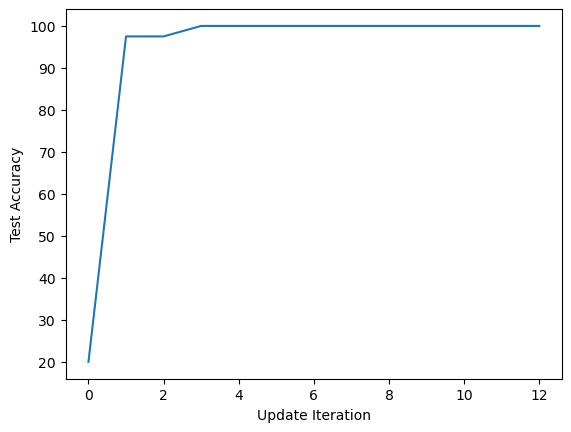

In [206]:
train_x, train_y = prepare_data(train_paths, train_labels, train_splits)
test_x, test_y = prepare_data(test_paths, test_labels, test_splits)


index = torch.arange(len(train_x))
accs = []


e = eval(model, test_x, test_y)
accs.append(e)
for epoch in range(num_epochs):
    epoch_loss = 0
    for x_i, y in zip(
        torch.split(index, split_size_or_sections=batch_size), 
        torch.split(train_y, split_size_or_sections=batch_size)
        ):
        x = [train_x[i] for i in x_i]

        epoch_loss += train(model, x, y, loss_fn=loss_fn, optimizer=optimizer)
        e = eval(model, test_x, test_y)
        accs.append(e)
    
    print(epoch_loss)
plt.xlabel('Update Iteration')
plt.ylabel('Test Accuracy')
plt.plot(np.arange(len(accs)), np.array(accs) * 100)
plt.show()